# Quickstart


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qc_lab import Simulation # import simulation class 
from qc_lab.models import SpinBoson # import model class 
from qc_lab.algorithms import MeanField # import algorithm class 
from qc_lab.dynamics import serial_driver # import dynamics driver

sim = Simulation()
print('default simulation settings: ', sim.default_settings)
# default simulation settings:  {'tmax': 10, 'dt': 0.01, 'dt_output': 0.1, 'num_trajs': 10, 'batch_size': 1}

# change settings to customize simulation
sim.settings.num_trajs = 200
sim.settings.batch_size = 50
sim.settings.tmax = 30
sim.settings.dt = 0.01

sim.model = SpinBoson()
print('default model constants: ', sim.model.default_constants)
# default model constants:  {'temp': 1, 'V': 0.5, 'E': 0.5, 'A': 100, 'W': 0.1, 'l_reorg': 0.005, 'boson_mass': 1}

sim.algorithm = MeanField()
print('default algorithm settings: ', sim.algorithm.default_settings)
# default algorithm settings:  {}

sim.state.wf_db= np.array([1, 0], dtype=complex)

data = serial_driver(sim)

default simulation settings:  {'tmax': 10, 'dt': 0.01, 'dt_output': 0.1, 'num_trajs': 10, 'batch_size': 1}
default model constants:  {'temp': 1, 'V': 0.5, 'E': 0.5, 'A': 100, 'W': 0.1, 'l_reorg': 0.005, 'boson_mass': 1}
default algorithm settings:  {}


100%|██████████| 3001/3001 [00:01<00:00, 2598.59it/s]


calculated quantities: dict_keys(['seed', 'dm_db', 'classical_energy', 'quantum_energy'])


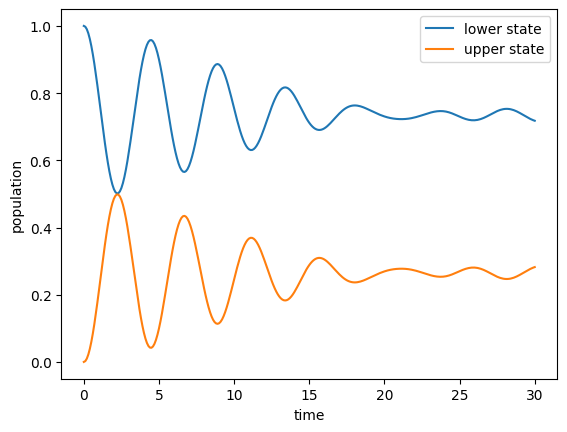

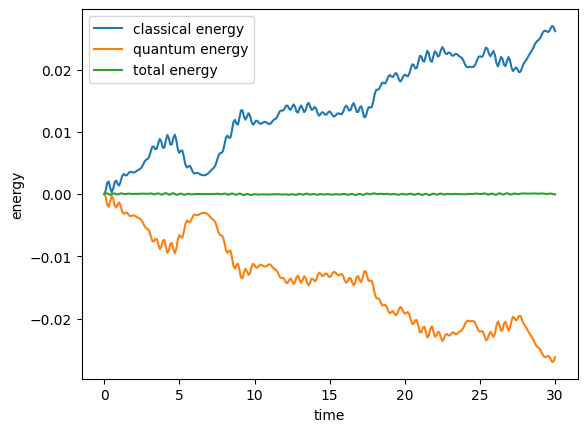

In [2]:
print('calculated quantities:', data.data_dic.keys())
num_trajs = len(data.data_dic['seed'])
classical_energy = data.data_dic['classical_energy']/num_trajs
quantum_energy = data.data_dic['quantum_energy']/num_trajs
populations = np.real(np.einsum('tii->ti', data.data_dic['dm_db']/num_trajs))
time = sim.settings.tdat_output
plt.plot(time, populations[:,0], label='lower state')
plt.plot(time, populations[:,1], label='upper state')
plt.xlabel('time')
plt.ylabel('population')
plt.legend()
plt.savefig('../docs/user_guide/quickstart/quickstart_populations.png')
plt.show()
plt.plot(time, classical_energy - classical_energy[0], label='classical energy')
plt.plot(time, quantum_energy - quantum_energy[0], label='quantum energy')
plt.plot(time, classical_energy + quantum_energy - classical_energy[0] - quantum_energy[0], label='total energy')
plt.xlabel('time')
plt.ylabel('energy')
plt.legend()
plt.savefig('../docs/user_guide/quickstart/quickstart_energies.png')
plt.show()

In [3]:
from qc_lab.algorithms import FewestSwitchesSurfaceHopping

sim.algorithm = FewestSwitchesSurfaceHopping()

data = serial_driver(sim)

100%|██████████| 3001/3001 [00:02<00:00, 1412.18it/s]


calculated quantities: dict_keys(['seed', 'quantum_energy', 'classical_energy', 'dm_db'])


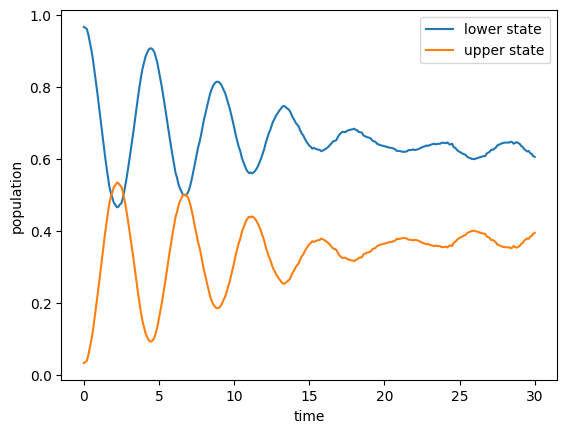

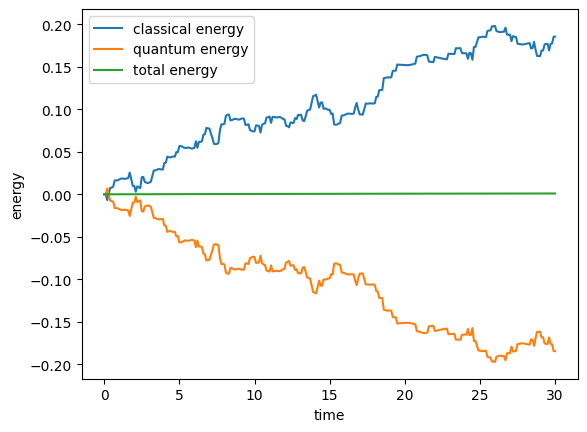

In [4]:
print('calculated quantities:', data.data_dic.keys())
num_trajs = len(data.data_dic['seed'])
classical_energy = data.data_dic['classical_energy']/num_trajs
quantum_energy = data.data_dic['quantum_energy']/num_trajs
populations = np.real(np.einsum('tii->ti', data.data_dic['dm_db']/num_trajs))
time = sim.settings.tdat_output
plt.plot(time, populations[:,0], label='lower state')
plt.plot(time, populations[:,1], label='upper state')
plt.xlabel('time')
plt.ylabel('population')
plt.legend()
plt.savefig('../docs/user_guide/quickstart/quickstart_populations_fssh.png')
plt.show()
plt.plot(time, classical_energy - classical_energy[0], label='classical energy')
plt.plot(time, quantum_energy - quantum_energy[0], label='quantum energy')
plt.plot(time, classical_energy + quantum_energy - classical_energy[0] - quantum_energy[0], label='total energy')
plt.xlabel('time')
plt.ylabel('energy')
plt.legend()
plt.savefig('../docs/user_guide/quickstart/quickstart_energies_fssh.png')
plt.show()

In [5]:
from qc_lab.dynamics import parallel_driver_multiprocessing

data = parallel_driver_multiprocessing(sim, num_tasks=4)

running  200 trajectories in batches of 50 on 4 tasks.


100%|██████████| 3001/3001 [00:03<00:00, 847.11it/s]


calculated quantities: dict_keys(['seed', 'quantum_energy', 'classical_energy', 'dm_db'])


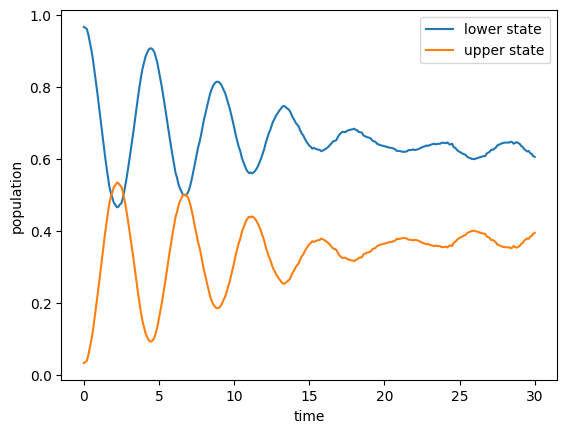

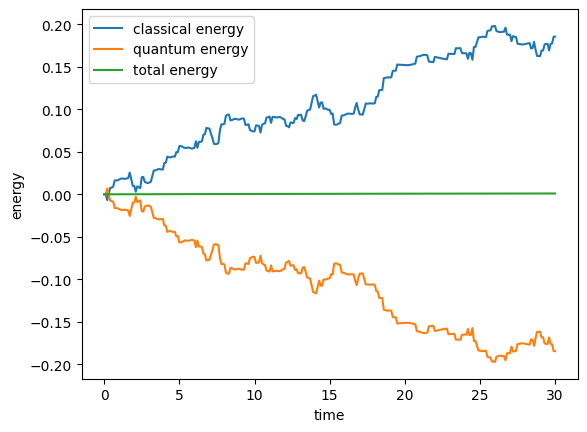

In [6]:
print('calculated quantities:', data.data_dic.keys())
num_trajs = len(data.data_dic['seed'])
classical_energy = data.data_dic['classical_energy']/num_trajs
quantum_energy = data.data_dic['quantum_energy']/num_trajs
populations = np.real(np.einsum('tii->ti', data.data_dic['dm_db']/num_trajs))
time = sim.settings.tdat_output
plt.plot(time, populations[:,0], label='lower state')
plt.plot(time, populations[:,1], label='upper state')
plt.xlabel('time')
plt.ylabel('population')
plt.legend()
#plt.savefig('../docs/user_guide/quickstart/quickstart_populations_fssh.png')
plt.show()
plt.plot(time, classical_energy - classical_energy[0], label='classical energy')
plt.plot(time, quantum_energy - quantum_energy[0], label='quantum energy')
plt.plot(time, classical_energy + quantum_energy - classical_energy[0] - quantum_energy[0], label='total energy')
plt.xlabel('time')
plt.ylabel('energy')
plt.legend()
#plt.savefig('../docs/user_guide/quickstart/quickstart_energies_fssh.png')
plt.show()

# Model Development

In [1]:
from qc_lab import Model
import qc_lab.ingredients as ingredients

class MinimalSpinBoson(Model):
    def __init__(self, constants=None):
        if constants is None:
            constants = {}
        self.default_constants = {
            'temp': 1, 'V': 0.5, 'E': 0.5, 'A': 100, 'W': 0.1,
            'l_reorg': 0.02 / 4, 'boson_mass': 1
        }
        super().__init__(self.default_constants, constants)

    def initialize_constants_model(self):
        num_bosons = self.constants.get("A", self.default_constants.get("A"))
        char_freq = self.constants.get("W", self.default_constants.get("W"))
        boson_mass = self.constants.get(
            "boson_mass", self.default_constants.get("boson_mass")
        )
        self.constants.w = char_freq * np.tan(
            ((np.arange(num_bosons) + 1) - 0.5) * np.pi / (2 * num_bosons)
        )
        # The following constants are required by QC Lab
        self.constants.num_classical_coordinates = num_bosons
        self.constants.num_quantum_states = 2
        self.constants.classical_coordinate_weight = self.constants.w
        self.constants.classical_coordinate_mass = boson_mass * np.ones(num_bosons)

    def initialize_constants_h_c(self):
        """
        Initialize the constants for the classical Hamiltonian.
        """
        w = self.constants.get("w", self.default_constants.get("w"))
        self.constants.harmonic_oscillator_frequency = w


    def initialize_constants_h_qc(self):
        """
        Initialize the constants for the quantum-classical coupling Hamiltonian.
        """
        num_bosons = self.constants.get("A", self.default_constants.get("A"))
        w = self.constants.get("w", self.default_constants.get("w"))
        l_reorg = self.constants.get("l_reorg", self.default_constants.get("l_reorg"))
        self.constants.spin_boson_coupling = w * np.sqrt(2 * l_reorg / num_bosons)

    def initialize_constants_h_q(self):
        """
        Initialize the constants for the quantum Hamiltonian. None are required in this case.
        """

    initialization_functions = [
        initialize_constants_model,
        initialize_constants_h_c,
        initialize_constants_h_qc,
        initialize_constants_h_q,
    ]

    @ingredients.vectorize_ingredient
    def h_q(self, constants, parameters, **kwargs):
        E = constants.E
        V = constants.V
        return np.array([[E, V], [V, -E]], dtype=complex)

    @ingredients.vectorize_ingredient
    def h_qc(self, constants, parameters, **kwargs):
        z = kwargs['z']
        g = constants.spin_boson_coupling
        m = constants.classical_coordinate_mass
        h = constants.classical_coordinate_weight
        h_qc = np.zeros((2, 2), dtype=complex)
        h_qc[0, 0] = np.sum((g * np.sqrt(1 / (2 * m * h))) * (z + np.conj(z)))
        h_qc[1, 1] = -h_qc[0, 0]
        return h_qc

    @ingredients.vectorize_ingredient
    def h_c(self, constants, parameters, **kwargs):
        z = kwargs['z']
        w = constants.harmonic_oscillator_frequency
        return np.sum(w * np.conj(z) * z)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qc_lab import Simulation 
from qc_lab.algorithms import MeanField, FewestSwitchesSurfaceHopping
from qc_lab.dynamics import serial_driver, parallel_driver_multiprocessing

# instantiate a simulation
sim = Simulation()
print('default simulation settings: ', sim.default_settings)

# change settings to customize simulation
sim.settings.num_trajs = 10
sim.settings.batch_size = 10
sim.settings.tmax = 10
sim.settings.dt = 0.01

# instantiate a model 
sim.model = MinimalSpinBoson()
print('default model constants: ', sim.model.default_constants) # print out default constants

# instantiate an algorithm 
#sim.algorithm = MeanField()
sim.algorithm = FewestSwitchesSurfaceHopping()
print('default algorithm settings: ', sim.algorithm.default_settings) # print out default settings



# define an initial diabatic wavefunction 
sim.state.wf_db = np.array([1, 0], dtype=complex)

# run the simulation
data = serial_driver(sim)

default simulation settings:  {'tmax': 10, 'dt': 0.01, 'dt_output': 0.1, 'num_trajs': 10, 'batch_size': 1}
default model constants:  {'temp': 1, 'V': 0.5, 'E': 0.5, 'A': 100, 'W': 0.1, 'l_reorg': 0.005, 'boson_mass': 1}
default algorithm settings:  {'fssh_deterministic': False, 'gauge_fixing': 0}


KeyboardInterrupt: 

calculated quantities: dict_keys(['seed', 'quantum_energy', 'classical_energy', 'dm_db'])


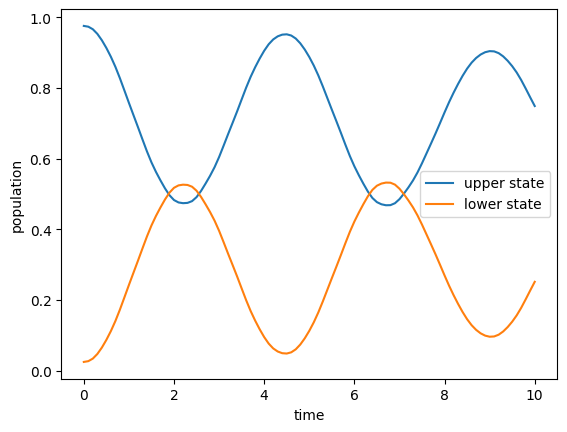

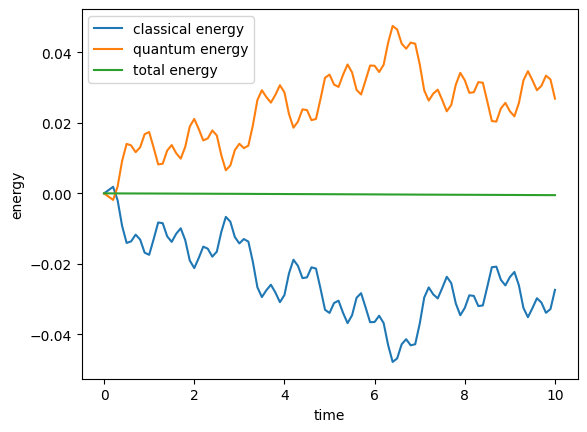

In [ ]:
print('calculated quantities:', data.data_dic.keys())
num_trajs = len(data.data_dic['seed'])
classical_energy = data.data_dic['classical_energy']/num_trajs
quantum_energy = data.data_dic['quantum_energy']/num_trajs
populations = np.real(np.einsum('tii->ti', data.data_dic['dm_db']/num_trajs))
time = sim.settings.tdat_output
plt.plot(time, populations[:,0], label='upper state')
plt.plot(time, populations[:,1], label='lower state')
plt.xlabel('time')
plt.ylabel('population')
plt.legend()
#plt.savefig('../docs/user_guide/quickstart/quickstart_populations.png')
plt.show()
plt.plot(time, classical_energy - classical_energy[0], label='classical energy')
plt.plot(time, quantum_energy - quantum_energy[0], label='quantum energy')
plt.plot(time, classical_energy + quantum_energy - classical_energy[0] - quantum_energy[0], label='total energy')
plt.xlabel('time')
plt.ylabel('energy')
plt.legend()
#plt.savefig('../docs/user_guide/quickstart/quickstart_energies.png')
plt.show()

### Upgrading the Model

In [8]:
from qc_lab import Model
import qc_lab.ingredients as ingredients
class UpgradedSpinBoson(Model):
    def __init__(self, constants=None):
        if constants is None:
            constants = {}
        self.default_constants = {
            'temp': 1, 'V': 0.5, 'E': 0.5, 'A': 100, 'W': 0.1,
            'l_reorg': 0.02 / 4, 'boson_mass': 1
        }
        self.dh_qc_dzc_inds = None
        self.dh_qc_dzc_mels = None
        self.dh_qc_dzc_shape = None
        self.linear_h_qc = True
        super().__init__(self.default_constants, constants)

    def initialize_constants_model(self):
        num_bosons = self.constants.get("A", self.default_constants.get("A"))
        char_freq = self.constants.get("W", self.default_constants.get("W"))
        boson_mass = self.constants.get(
            "boson_mass", self.default_constants.get("boson_mass")
        )
        self.constants.w = char_freq * np.tan(
            ((np.arange(num_bosons) + 1) - 0.5) * np.pi / (2 * num_bosons)
        )
        # The following constants are required by QC Lab
        self.constants.num_classical_coordinates = num_bosons
        self.constants.num_quantum_states = 2
        self.constants.classical_coordinate_weight = self.constants.w
        self.constants.classical_coordinate_mass = boson_mass * np.ones(num_bosons)

    def initialize_constants_h_c(self):
        """
        Initialize the constants for the classical Hamiltonian.
        """
        w = self.constants.get("w", self.default_constants.get("w"))
        self.constants.harmonic_oscillator_frequency = w


    def initialize_constants_h_qc(self):
        """
        Initialize the constants for the quantum-classical coupling Hamiltonian.
        """
        num_bosons = self.constants.get("A", self.default_constants.get("A"))
        w = self.constants.get("w", self.default_constants.get("w"))
        l_reorg = self.constants.get("l_reorg", self.default_constants.get("l_reorg"))
        self.constants.spin_boson_coupling = w * np.sqrt(2 * l_reorg / num_bosons)

    def initialize_constants_h_q(self):
        """
        Initialize the constants for the quantum Hamiltonian. None are required in this case.
        """

    initialization_functions = [
        initialize_constants_model,
        initialize_constants_h_c,
        initialize_constants_h_qc,
        initialize_constants_h_q,
    ]

    def h_q(self, constants, parameters, **kwargs):
        if kwargs.get("batch_size") is not None:
            batch_size = kwargs.get("batch_size")
        else:
            batch_size = len(parameters.seed)
        E = constants.E
        V = constants.V
        h_q = np.zeros((batch_size, 2, 2), dtype=complex)
        h_q[:, 0, 0] = E
        h_q[:, 1, 1] = -E
        h_q[:, 0, 1] = V
        h_q[:, 1, 0] = V
        return h_q


    def h_qc(self, constants, parameters, **kwargs):
        z = kwargs.get("z")
        if kwargs.get("batch_size") is not None:
            batch_size = kwargs.get("batch_size")
            assert len(z) == batch_size
        else:
            batch_size = len(z)
        g = constants.spin_boson_coupling
        m = constants.classical_coordinate_mass
        h = constants.classical_coordinate_weight
        h_qc = np.zeros((batch_size, 2, 2), dtype=complex)
        h_qc[:, 0, 0] = np.sum(
            g * np.sqrt(1 / (2 * m * h))[np.newaxis, :] * (z + np.conj(z)), axis=-1
        )
        h_qc[:, 1, 1] = -h_qc[:, 0, 0]
        return h_qc

    def h_c(self, constants, parameters, **kwargs):
        z = kwargs.get("z")
        if kwargs.get("batch_size") is not None:
            batch_size = kwargs.get("batch_size")
            assert len(z) == batch_size
        else:
            batch_size = len(z)

        h = constants.classical_coordinate_weight[np.newaxis, :]
        w = constants.harmonic_oscillator_frequency[np.newaxis, :]
        m = constants.classical_coordinate_mass[np.newaxis, :]
        q = np.sqrt(2 / (m * h)) * np.real(z)
        p = np.sqrt(2 * m * h) * np.imag(z)
        h_c = np.sum((1 / 2) * (((p**2) / m) + m * (w**2) * (q**2)), axis=-1)
        return h_c
    
    def dh_c_dzc(self, constants, parameters, **kwargs):
        z = kwargs.get("z")
        if kwargs.get("batch_size") is not None:
            batch_size = kwargs.get("batch_size")
            assert len(z) == batch_size
        else:
            batch_size = len(z)
        h = constants.classical_coordinate_weight
        w = constants.harmonic_oscillator_frequency
        a = (1 / 4) * (
            ((w**2) / h) - h
        )
        b = (1 / 4) * (
            ((w**2) / h) + h
        )
        dh_c_dzc = 2 * b[..., :] * z + 2 *a[..., :] * np.conj(z)
        return dh_c_dzc
    
    def dh_qc_dzc(self, constants, parameters, **kwargs):
        z = kwargs.get("z")
        if kwargs.get("batch_size") is not None:
            batch_size = kwargs.get("batch_size")
            assert len(z) == batch_size
        else:
            batch_size = len(z)

        recalculate = False
        if self.dh_qc_dzc_shape is not None:
            if self.dh_qc_dzc_shape[0] != batch_size:
                recalculate = True

        if (
            self.dh_qc_dzc_inds is None
            or self.dh_qc_dzc_mels is None
            or self.dh_qc_dzc_shape is None
            or recalculate
        ):

            m = constants.classical_coordinate_mass
            g = constants.spin_boson_coupling
            h = constants.classical_coordinate_weight
            dh_qc_dzc = np.zeros((batch_size, constants.A, 2, 2), dtype=complex)
            dh_qc_dzc[:, :, 0, 0] = (g * np.sqrt(1 / (2 * m * h)))[..., :]
            dh_qc_dzc[:, :, 1, 1] = -dh_qc_dzc[..., :, 0, 0]
            inds = np.where(dh_qc_dzc != 0)
            mels = dh_qc_dzc[inds]
            shape = np.shape(dh_qc_dzc)
            self.dh_qc_dzc_inds = inds
            self.dh_qc_dzc_mels = dh_qc_dzc[inds]
            self.dh_qc_dzc_shape = shape
        else:
            inds = self.dh_qc_dzc_inds
            mels = self.dh_qc_dzc_mels
            shape = self.dh_qc_dzc_shape
        return inds, mels, shape
    
    def init_classical(model, constants, parameters, **kwargs):
        del model, parameters
        seed = kwargs.get("seed", None)
        kbt = constants.temp
        h = constants.classical_coordinate_weight
        w = constants.harmonic_oscillator_frequency
        m = constants.classical_coordinate_mass
        out = np.zeros((len(seed), constants.num_classical_coordinates), dtype=complex)
        for s, seed_value in enumerate(seed):
            np.random.seed(seed_value)
            # Calculate the standard deviations for q and p.
            std_q = np.sqrt(kbt / (m * (w**2)))
            std_p = np.sqrt(m * kbt)
            # Generate random q and p values.
            q = np.random.normal(
                loc=0, scale=std_q, size=constants.num_classical_coordinates
            )
            p = np.random.normal(
                loc=0, scale=std_p, size=constants.num_classical_coordinates
            )
            # Calculate the complex classical coordinate.
            z = np.sqrt(h * m / 2) * (q + 1.0j * (p / (h * m)))
            out[s] = z
        return out

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from qc_lab import Simulation 
from qc_lab.algorithms import MeanField, FewestSwitchesSurfaceHopping
from qc_lab.dynamics import serial_driver, parallel_driver_multiprocessing

# instantiate a simulation
sim = Simulation()
print('default simulation settings: ', sim.default_settings)

# change settings to customize simulation
sim.settings.num_trajs = 10
sim.settings.batch_size = 10
sim.settings.tmax = 10
sim.settings.dt = 0.001

# instantiate a model 
sim.model = UpgradedSpinBoson()
print('default model constants: ', sim.model.default_constants) # print out default constants

# instantiate an algorithm 
sim.algorithm = FewestSwitchesSurfaceHopping()
print('default algorithm settings: ', sim.algorithm.default_settings) # print out default settings



# define an initial diabatic wavefunction 
sim.state.wf_db = np.array([1, 0], dtype=complex)

# run the simulation
data = serial_driver(sim)

default simulation settings:  {'tmax': 10, 'dt': 0.01, 'dt_output': 0.1, 'num_trajs': 10, 'batch_size': 1}
default model constants:  {'temp': 1, 'V': 0.5, 'E': 0.5, 'A': 100, 'W': 0.1, 'l_reorg': 0.005, 'boson_mass': 1}
default algorithm settings:  {'fssh_deterministic': False, 'gauge_fixing': 0}


100%|██████████| 10001/10001 [00:04<00:00, 2207.88it/s]


calculated quantities: dict_keys(['seed', 'quantum_energy', 'classical_energy', 'dm_db'])


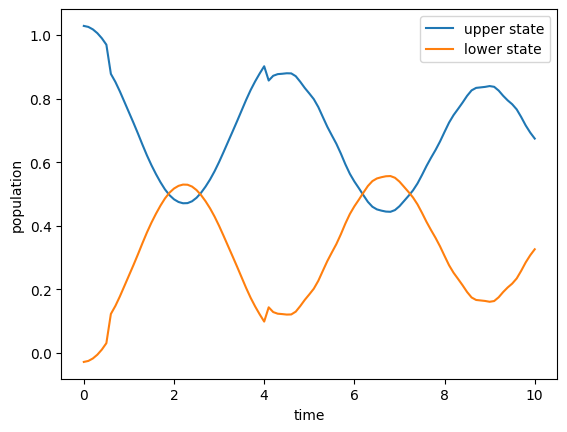

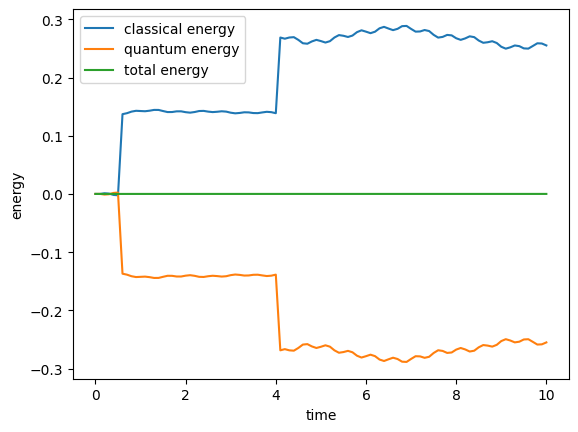

In [10]:
print('calculated quantities:', data.data_dic.keys())
num_trajs = len(data.data_dic['seed'])
classical_energy = data.data_dic['classical_energy']/num_trajs
quantum_energy = data.data_dic['quantum_energy']/num_trajs
populations = np.real(np.einsum('tii->ti', data.data_dic['dm_db']/num_trajs))
time = sim.settings.tdat_output
plt.plot(time, populations[:,0], label='upper state')
plt.plot(time, populations[:,1], label='lower state')
plt.xlabel('time')
plt.ylabel('population')
plt.legend()
#plt.savefig('../docs/user_guide/quickstart/quickstart_populations.png')
plt.show()
plt.plot(time, classical_energy - classical_energy[0], label='classical energy')
plt.plot(time, quantum_energy - quantum_energy[0], label='quantum energy')
plt.plot(time, classical_energy + quantum_energy - classical_energy[0] - quantum_energy[0], label='total energy')
plt.xlabel('time')
plt.ylabel('energy')
plt.legend()
#plt.savefig('../docs/user_guide/quickstart/quickstart_energies.png')
plt.show()

### Using Built-in ingredients

In [ ]:
import qc_lab.ingredients as ingredients

model = MinimalSpinBoson

model.h_q = ingredients.two_level_system_h_q

def initialize_constants_h_q(model):
    """
    Initialize the constants for the quantum Hamiltonian.
    """
    model.constants.two_level_system_a = model.constants.get(
        "E", model.default_constants.get("E")
    )
    model.constants.two_level_system_b = -model.constants.get(
        "E", model.default_constants.get("E")
    )
    model.constants.two_level_system_c = model.constants.get(
        "V", model.default_constants.get("V")
    )
    model.constants.two_level_system_d = 0

model.initialize_constants_h_q = initialize_constants_h_q
# also update the list of initialization functions
model.initialization_functions[3] = initialize_constants_h_q

def initialize_constants_h_c(model):
    """
    Initialize the constants for the classical Hamiltonian.
    """
    w = model.constants.get("w", model.default_constants.get("w"))
    model.constants.harmonic_oscillator_frequency = w

model.h_c = ingredients.harmonic_oscillator_h_c
model.initialize_constants_h_c = initialize_constants_h_c
model.initialization_functions[1] = initialize_constants_h_c

model.dh_c_dzc = ingredients.harmonic_oscillator_dh_c_dzc

model.h_qc = ingredients.spin_boson_h_qc
model.dh_qc_dzc = ingredients.spin_boson_dh_qc_dzc
model.dh_qc_dzc_inds = None
model.dh_qc_dzc_mels = None
model.dh_qc_dzc_shape = None

model.init_classical = ingredients.harmonic_oscillator_boltzmann_init_classical

model.hop_function = ingredients.harmonic_oscillator_hop_function

model.linear_h_qc = True

UpgradedBuiltInSpinBoson = model

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from qc_lab import Simulation 
from qc_lab.algorithms import MeanField, FewestSwitchesSurfaceHopping
from qc_lab.dynamics import serial_driver, parallel_driver_multiprocessing
from qc_lab.models import SpinBoson

# instantiate a simulation
sim = Simulation()
print('default simulation settings: ', sim.default_settings)

# change settings to customize simulation
sim.settings.num_trajs = 10
sim.settings.batch_size = 10
sim.settings.tmax = 10
sim.settings.dt = 0.001

# instantiate a model 
sim.model = UpgradedBuiltInSpinBoson()
print('default model constants: ', sim.model.default_constants) # print out default constants

# instantiate an algorithm 
#sim.algorithm = MeanField()
sim.algorithm = FewestSwitchesSurfaceHopping()
print('default algorithm settings: ', sim.algorithm.default_settings) # print out default settings



# define an initial diabatic wavefunction 
sim.state.wf_db = np.array([1, 0], dtype=complex)

# run the simulation
data = serial_driver(sim)

default simulation settings:  {'tmax': 10, 'dt': 0.01, 'dt_output': 0.1, 'num_trajs': 10, 'batch_size': 1}
default model constants:  {'temp': 1, 'V': 0.5, 'E': 0.5, 'A': 100, 'W': 0.1, 'l_reorg': 0.005, 'boson_mass': 1}
default algorithm settings:  {'fssh_deterministic': False, 'gauge_fixing': 0}


100%|██████████| 10001/10001 [00:03<00:00, 2533.56it/s]


calculated quantities: dict_keys(['seed', 'quantum_energy', 'classical_energy', 'dm_db'])


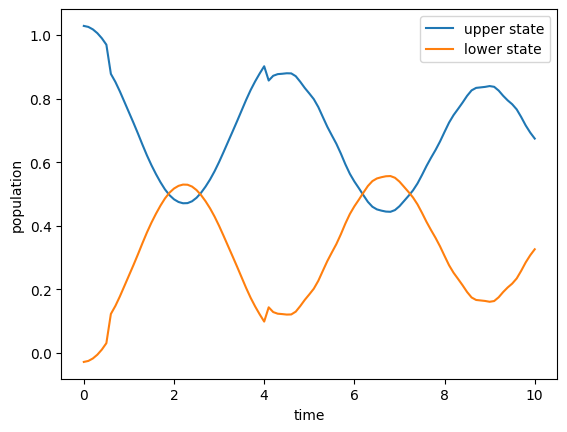

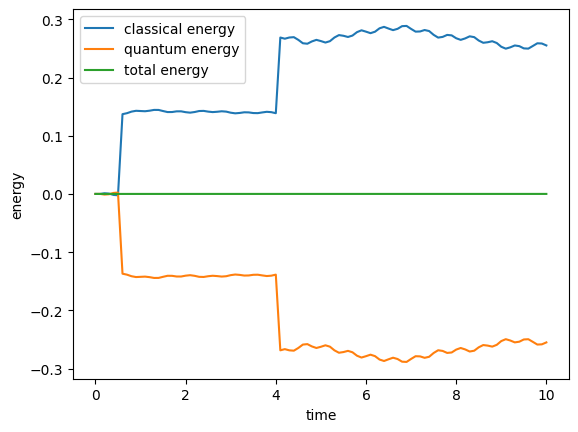

In [13]:
print('calculated quantities:', data.data_dic.keys())
num_trajs = len(data.data_dic['seed'])
classical_energy = data.data_dic['classical_energy']/num_trajs
quantum_energy = data.data_dic['quantum_energy']/num_trajs
populations = np.real(np.einsum('tii->ti', data.data_dic['dm_db']/num_trajs))
time = sim.settings.tdat_output
plt.plot(time, populations[:,0], label='upper state')
plt.plot(time, populations[:,1], label='lower state')
plt.xlabel('time')
plt.ylabel('population')
plt.legend()
#plt.savefig('../docs/user_guide/quickstart/quickstart_populations.png')
plt.show()
plt.plot(time, classical_energy - classical_energy[0], label='classical energy')
plt.plot(time, quantum_energy - quantum_energy[0], label='quantum energy')
plt.plot(time, classical_energy + quantum_energy - classical_energy[0] - quantum_energy[0], label='total energy')
plt.xlabel('time')
plt.ylabel('energy')
plt.legend()
#plt.savefig('../docs/user_guide/quickstart/quickstart_energies.png')
plt.show()

# Algorithm Development

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qc_lab.algorithms import MeanField

# the initialization recipe
print(MeanField.initialization_recipe)

# the update recipe
print(MeanField.update_recipe)

# the output recipe
print(MeanField.output_recipe)

def update_adiabatic_populations(sim, parameters, state, **kwargs):
    # First get the Hamiltonian and calculate its eigenvalues and eigenvectors.
    H = state.h_quantum # this is the quantum plus quantum-classical Hamiltonian.
    # Next obtain its eigenvalues and eigenvectors.
    evals, evecs = np.linalg.eigh(H)
    # Now calculate the adiabatic wavefunction.
    wf_adb = np.einsum('tji,tj->ti', np.conj(evecs), state.wf_db)
    # Finally calculate the populations (note that we do not sum over the batch).
    pops_adb = np.abs(wf_adb)**2
    # Store the populations in the state object.
    state.pops_adb = pops_adb
    return parameters, state

MeanField.output_recipe.append(update_adiabatic_populations)

MeanField.output_variables.append('pops_adb')


[<function MeanField.<lambda> at 0x7b040b550b80>, <function MeanField.<lambda> at 0x7b040b550c10>, <function MeanField.<lambda> at 0x7b040b550ca0>]
[<function MeanField.<lambda> at 0x7b040b550d30>, <function MeanField.<lambda> at 0x7b040b550dc0>, <function update_wf_db_rk4 at 0x7b040b51fc70>]
[<function update_dm_db_mf at 0x7b040b51fe20>, <function MeanField.<lambda> at 0x7b040b550e50>, <function MeanField.<lambda> at 0x7b040b550ee0>]


In [ ]:
from qc_lab import Simulation 
from qc_lab.dynamics import serial_driver
from qc_lab.models import SpinBoson

# instantiate a simulation
sim = Simulation()
print('default simulation settings: ', sim.default_settings)

# change settings to customize simulation
sim.settings.num_trajs = 100
sim.settings.batch_size = 100
sim.settings.tmax = 25
sim.settings.dt = 0.01

# instantiate a model 
sim.model = SpinBoson()
print('default model constants: ', sim.model.default_constants) # print out default constants

# instantiate an algorithm 
sim.algorithm = MeanField()
print('default algorithm settings: ', sim.algorithm.default_settings) # print out default settings



# define an initial diabatic wavefunction 
sim.state.wf_db = np.array([1, 0], dtype=complex)

# run the simulation
data = serial_driver(sim)

default simulation settings:  {'tmax': 10, 'dt': 0.01, 'dt_output': 0.1, 'num_trajs': 10, 'batch_size': 1}
default model constants:  {'temp': 1, 'V': 0.5, 'E': 0.5, 'A': 100, 'W': 0.1, 'l_reorg': 0.005, 'boson_mass': 1}
default algorithm settings:  {}


  0%|          | 0/2501 [00:00<?, ?it/s]

100%|██████████| 2501/2501 [00:02<00:00, 863.44it/s] 


calculated quantities: dict_keys(['seed', 'dm_db', 'classical_energy', 'quantum_energy', 'pops_adb'])
(251, 2)


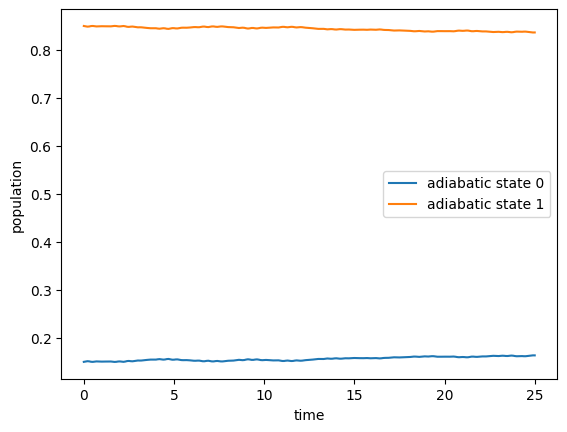

In [5]:
print('calculated quantities:', data.data_dic.keys())
num_trajs = len(data.data_dic['seed'])
classical_energy = data.data_dic['classical_energy']/num_trajs
quantum_energy = data.data_dic['quantum_energy']/num_trajs
populations = np.real(np.einsum('tii->ti', data.data_dic['dm_db']/num_trajs))
adiabatic_populations = np.real(data.data_dic['pops_adb']/num_trajs)
time = sim.settings.tdat_output
plt.plot(time, adiabatic_populations[:,0], label='adiabatic state 0')
plt.plot(time, adiabatic_populations[:,1], label='adiabatic state 1')
plt.xlabel('time')
plt.ylabel('population')
plt.legend()
#plt.savefig('../docs/user_guide/quickstart/quickstart_populations.png')
plt.show()